In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.cluster import DBSCAN


custom_palette = sns.color_palette('Set1')
plt.rcParams.update({'figure.figsize' : (12,6)})

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('OG_DATA/train.csv')
test = pd.read_csv('OG_DATA/sample_submission.csv')
med = pd.read_csv('OG_DATA/med.csv')

db = train.copy()
iqr = train.copy()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40152 entries, 0 to 40151
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Tarih                   40152 non-null  object 
 1   Dağıtılan Enerji (MWh)  40152 non-null  float64
dtypes: float64(1), object(1)
memory usage: 627.5+ KB


In [3]:
train.rename(columns={'Tarih' : 'date', 'Dağıtılan Enerji (MWh)' : 'target'},inplace=True)
train.date = pd.to_datetime(train.date)
train.date.nunique()

40152

In [4]:
train.isna().sum()

date      0
target    0
dtype: int64

In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
target,40152.0,1836.805287,426.066085,870.18328,1499.165048,1813.409221,2129.407998,3633.105297


__Extracting calendar features__

In [6]:
def date_extractor(df):
    
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day_ofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df.day_ofweek.apply(lambda x: 1 if x >= 5 else 0)
    df['day'] = df['date'].dt.day
    df['day_ofyear'] = df['date'].dt.dayofyear
    df['hour'] = df.date.dt.hour
    df['weekofyear'] = df['date'].dt.weekofyear
    df['quarter'] = df['date'].dt.quarter
    df['is_leap'] = df['date'].dt.is_leap_year.replace({False : 0, True : 1})
    
date_extractor(train)


season_map = {12: 'winter', 1: 'winter', 2: 'winter',
              3: 'spring', 4: 'spring', 5: 'spring',
              6: 'summer', 7: 'summer', 8: 'summer',
              9: 'fall', 10: 'fall', 11: 'fall'}

train['season'] = train.month.map(season_map)

train.set_index('date',inplace=True)

train['is_med'] = 0
train['is_med'].loc[med.Tarih.values] = 1

train

,target,year,month,day_ofweek,is_weekend,day,day_ofyear,hour,weekofyear,quarter,is_leap,season,is_med
date,,,,,,,,,,,,,
2018-01-01 00:00:00,1593.944216,2018,1,0,0,1,1,0,1,1,0,winter,0
2018-01-01 01:00:00,1513.933887,2018,1,0,0,1,1,1,1,1,0,winter,0
2018-01-01 02:00:00,1402.612637,2018,1,0,0,1,1,2,1,1,0,winter,0
2018-01-01 03:00:00,1278.527266,2018,1,0,0,1,1,3,1,1,0,winter,0
2018-01-01 04:00:00,1220.697701,2018,1,0,0,1,1,4,1,1,0,winter,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31 19:00:00,2492.489498,2022,7,6,1,31,212,19,30,3,0,summer,0
2022-07-31 20:00:00,2479.958245,2022,7,6,1,31,212,20,30,3,0,summer,0
2022-07-31 21:00:00,2485.016884,2022,7,6,1,31,212,21,30,3,0,summer,0


***
## EDA Plots


__Yearly__

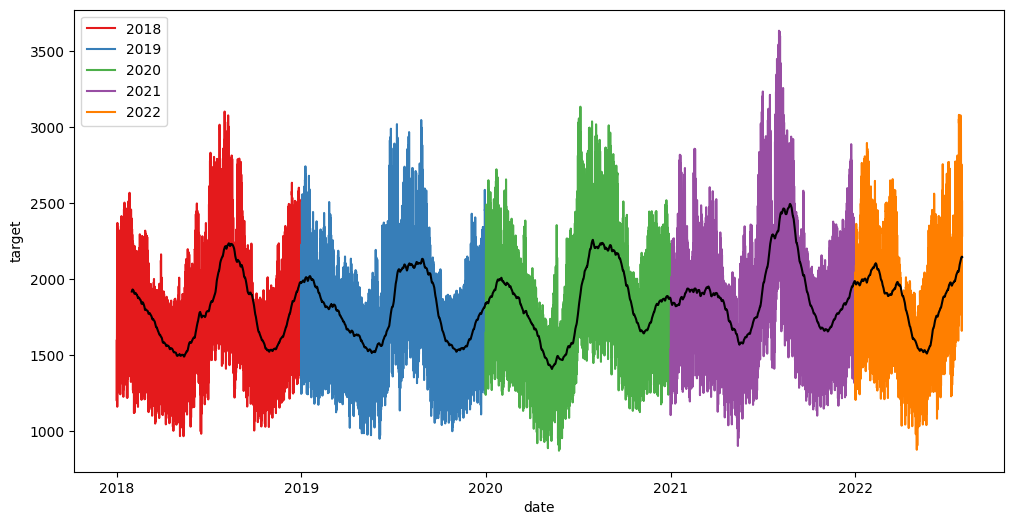

In [7]:
sns.lineplot(data=train,x=train.index,y='target',hue='year',palette=custom_palette)
sns.lineplot(data=train,x=train.index,y=train.target.rolling(24*30).mean(),color='black')
plt.show()

__Seasonally__

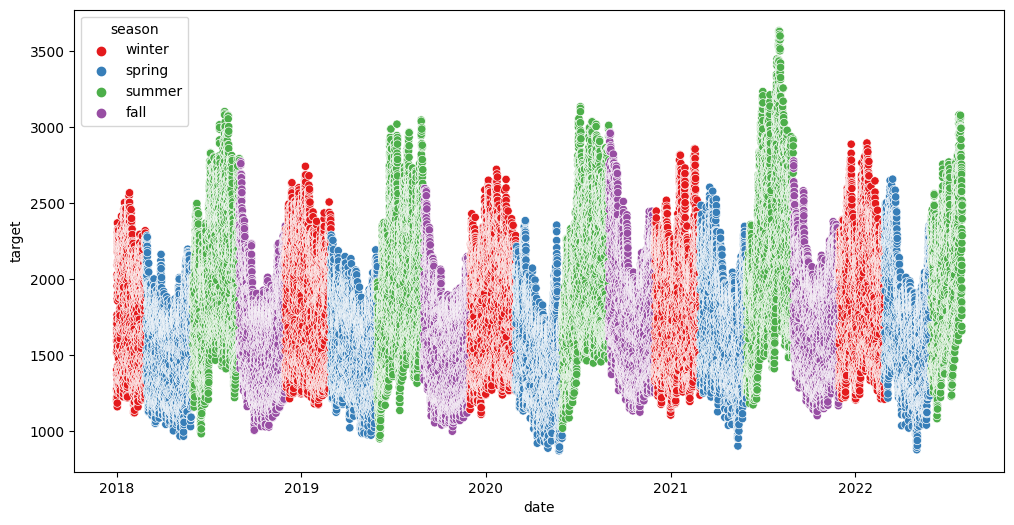

In [8]:
sns.scatterplot(data=train,x=train.index,y='target',hue='season',palette=custom_palette)
plt.show()

* __Is it a leap year?__
* __Comparing weekdays and weekends__

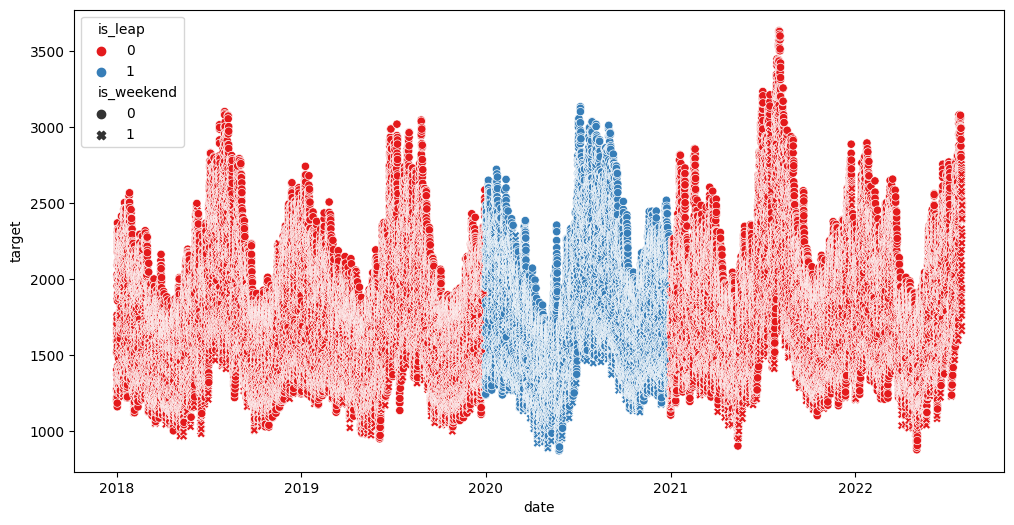

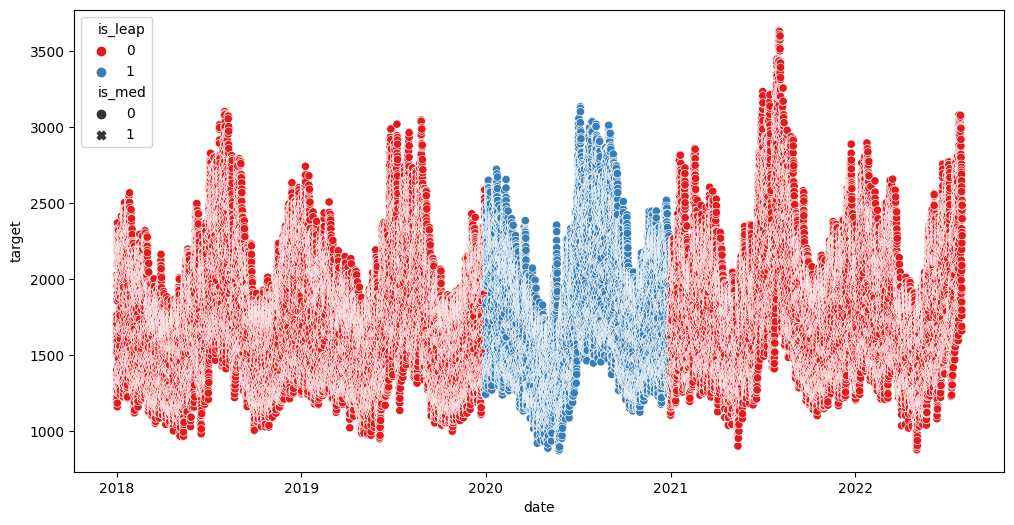

In [9]:
train['is_weekend'] = np.where(train['day_ofweek']>=5, 1, 0)

sns.scatterplot(data=train,x=train.index,y='target',hue='is_leap',style='is_weekend',palette=custom_palette)
plt.show()

sns.scatterplot(data=train,x=train.index,y='target',hue='is_leap',style='is_med',palette=custom_palette)
plt.show()

__Which time of the day has higher/lower energy usage? How does this change with seasons?__

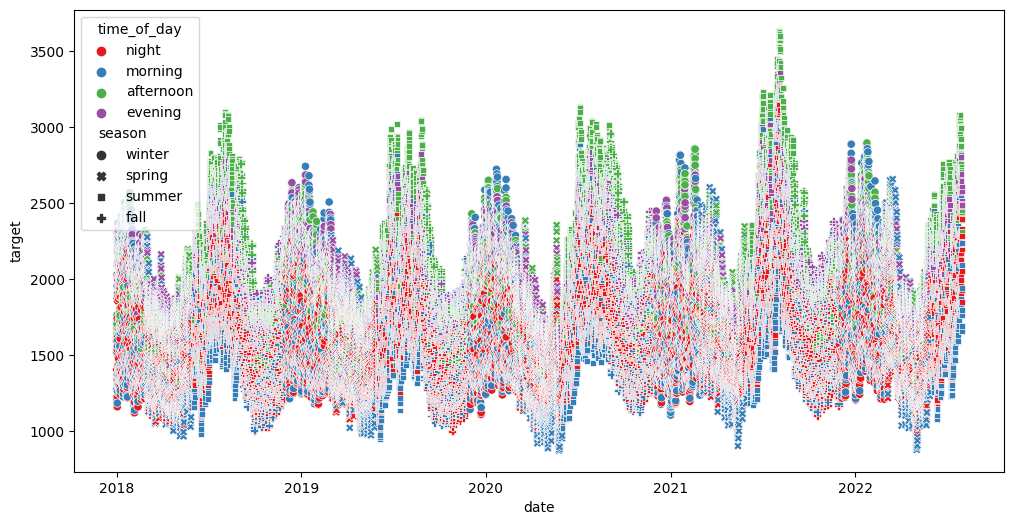

In [10]:
def map_hour_to_time_period(hour):
    
    if hour >= 5 and hour < 12:
        return 'morning'
    elif hour >= 12 and hour <= 17:
        return 'afternoon'
    elif hour >= 18 and hour <= 21:
        return 'evening'
    else:
        return 'night'

train['time_of_day'] = train['hour'].apply(map_hour_to_time_period)

sns.scatterplot(data=train,x=train.index,y='target',hue='time_of_day',style='season',palette=custom_palette)
plt.show()

__Grouping numeric variables__

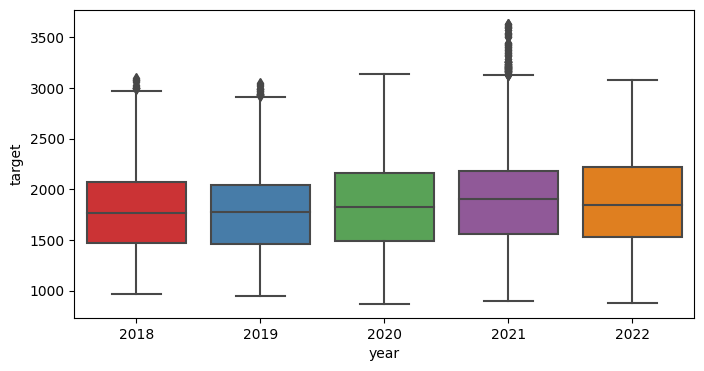

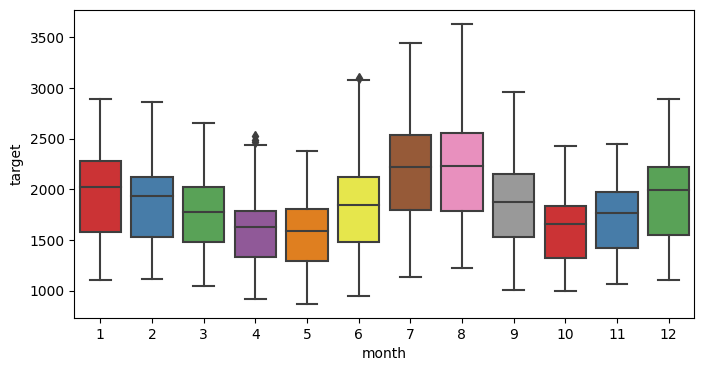

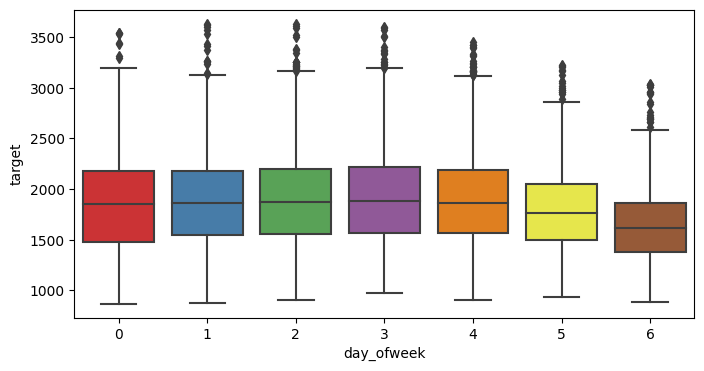

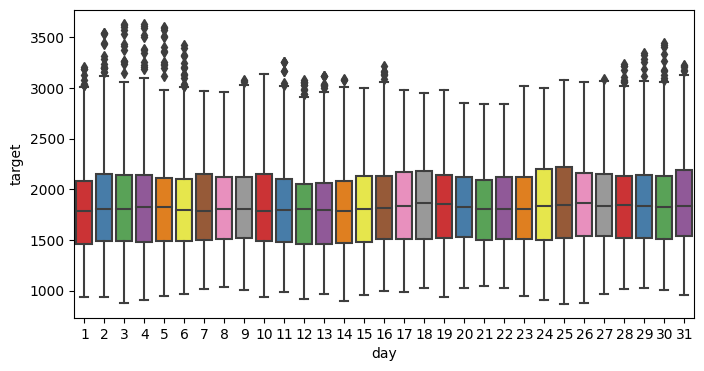

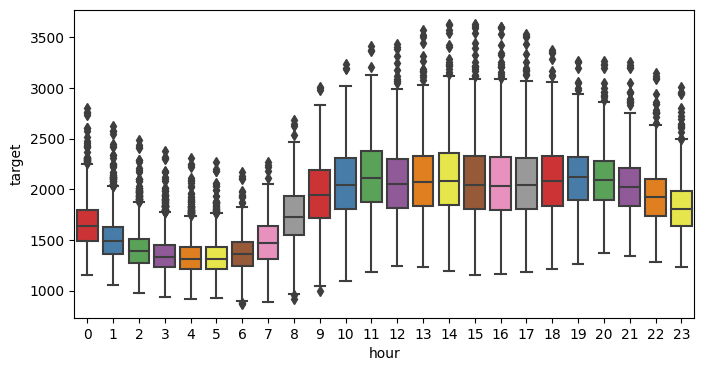

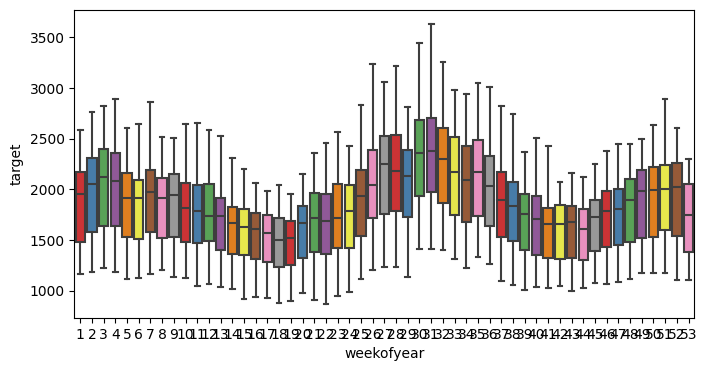

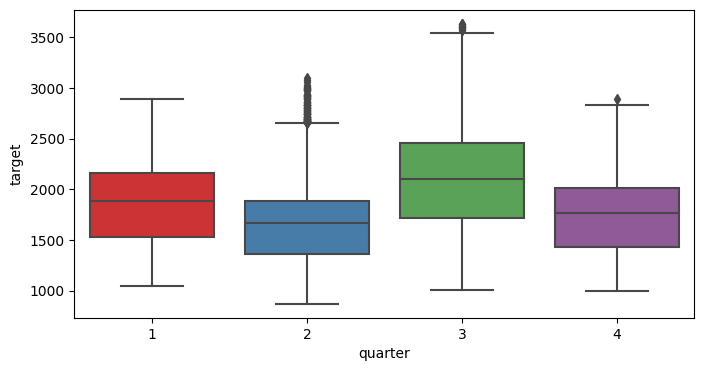

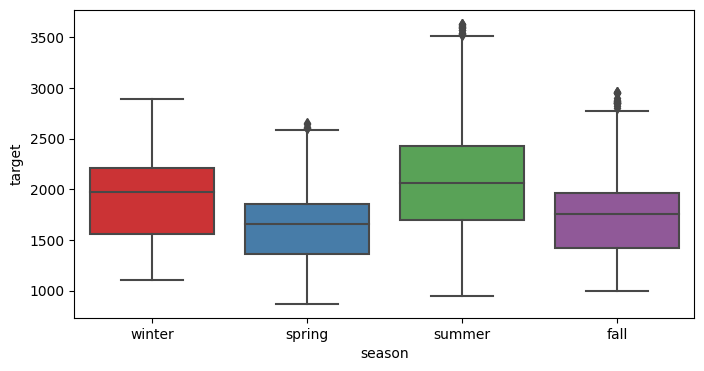

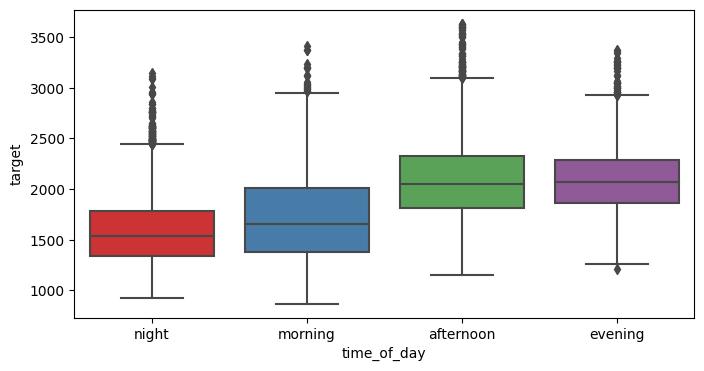

In [11]:
axes = train.columns[1:].to_list()
axes.remove('is_leap')
axes.remove('day_ofyear')
axes.remove('is_weekend')
axes.remove('is_med')

for a in axes:
    plt.subplots(figsize=(8,4))
    sns.boxplot(data=train,x=a,y='target',palette=custom_palette)
    plt.show()

__Categoric variables__

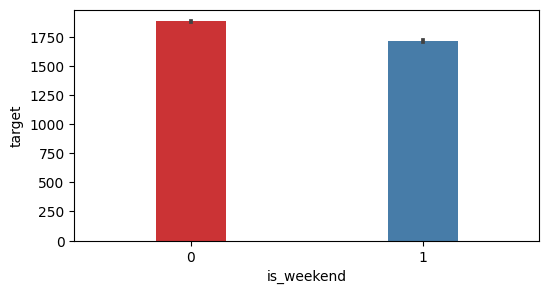

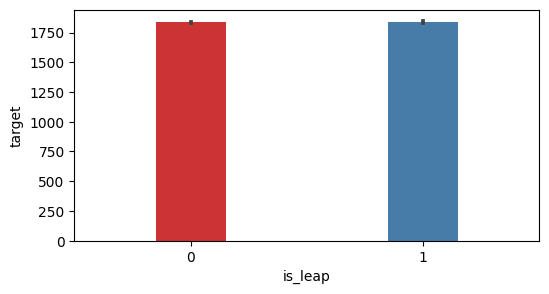

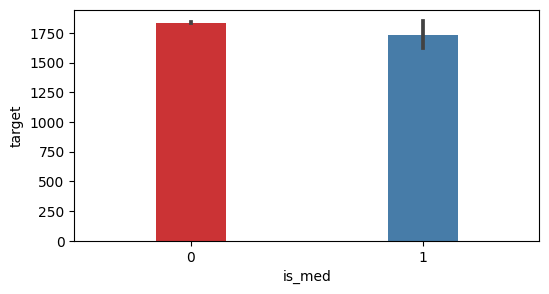

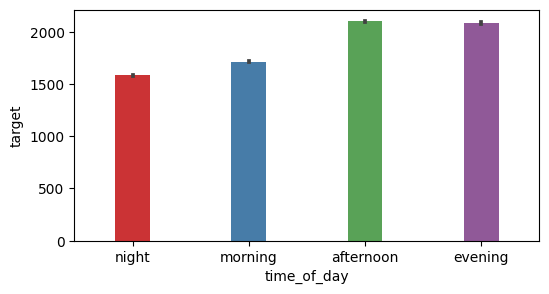

In [13]:
for item in ['is_weekend', 'is_leap', 'is_med', 'time_of_day']:
    plt.subplots(figsize=(6,3))
    sns.barplot(data=train, x=item,y= 'target',palette=custom_palette, width=0.3)
    plt.show()